In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re as re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")

import wandb
wandb.login(key=secret_value_0)

In [ ]:
import os

# data_path = "/kaggle/input/allthenews"
data_path = "../data/raw"
print(os.listdir(data_path))

['articles1.csv', 'articles2.csv', 'articles3.csv']


In [ ]:
df1 = pd.read_csv(f'{data_path}/articles1.csv')
df2 = pd.read_csv(f'{data_path}/articles2.csv')
df3 = pd.read_csv(f'{data_path}/articles3.csv')

In [ ]:
dff = pd.concat([df1,df2,df3])
dff = dff[['publication', 'content']]
dff.shape

(142570, 2)

In [ ]:
media_outlets = dff['publication'].unique()

In [ ]:
media_bias = {
    "Breitbart": "Right",
    "New York Post": "Lean Right",
    "NPR": "Lean Left",
    "CNN": "Lean Left",
    "Washington Post": "Lean Left",
    "Reuters": "Center",
    "Guardian": "Left",
    "New York Times": "Lean Left",
    "Atlantic": "Left",
    "Business Insider": "Lean Left",
    "National Review": "Lean Right",
    "Talking Points Memo": "NA",
    "Vox": "Left",
    "Buzzfeed News": "NA",
    "Fox News": "Right"
}

In [ ]:
media_data = dff.sample(frac=1)

In [ ]:
for media_outlet in media_outlets:
  if media_bias[media_outlet] and media_bias[media_outlet] != "NA":
    media_data.loc[media_data['publication'] == media_outlet, 'publication'] = media_bias[media_outlet]
  else:
    media_data = media_data[media_data['publication'] != media_outlet]

media_data = media_data.rename(columns={'publication': 'bias'})
media_data['bias'].value_counts()

bias
Lean Left     49154
Right         28135
Lean Right    23696
Left          20807
Center        10710
Name: count, dtype: int64

In [ ]:
# Take 30% samples for quick test
sample = media_data.sample(frac=0.2, random_state=42)

In [ ]:
# 5. Data Preprocessing-1  for 'content' attribute

#Lower case, Replace publications and special charactor with empty space
import re
from sklearn.feature_extraction import text
import spacy

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])


URL_RE = re.compile(r"http\S+|www\S+")
MULTI_SPACE_RE = re.compile(r"\s+")
HTML_RE = re.compile(r"<.*?>")
REPLACE_BY_SPACE_RE = re.compile(r"[/(){}\[\]\|@,;]")
BAD_SYMBOLS_RE = re.compile(r"[^0-9a-z #+_]")

def preprocess(text):
    text = text.lower()
    text = URL_RE.sub(' ', text)
    text = HTML_RE.sub(' ', text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub(' ', text)
    text = MULTI_SPACE_RE.sub(' ', text)

    for outlet in media_outlets:
        text = text.replace(outlet.lower(), '')

    doc = nlp(text)

    tokens = [
        token.lemma_
        for token in doc
        if token.is_alpha
        and not token.is_stop
        and len(token.text) > 3
    ]

    return " ".join(tokens)

sample["content"] = sample["content"].apply(preprocess)

Total words: 9179740


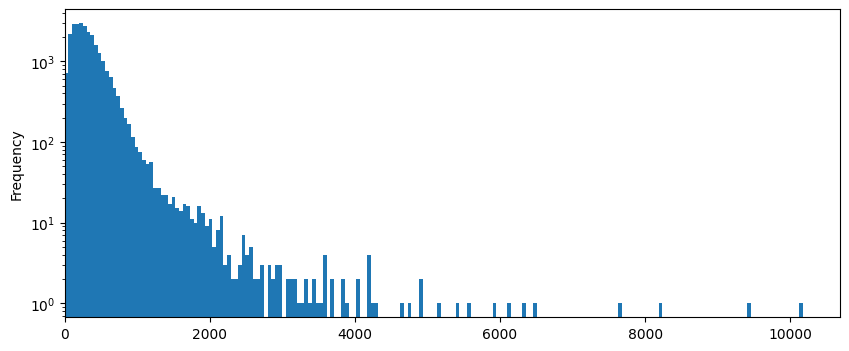

In [ ]:
s = sample['content'].str.split().str.len()
plt.figure(figsize=(10, 4))
s.plot.hist(bins=200)
plt.xlim(0)
plt.yscale('log')
print("Total words:",s.sum())

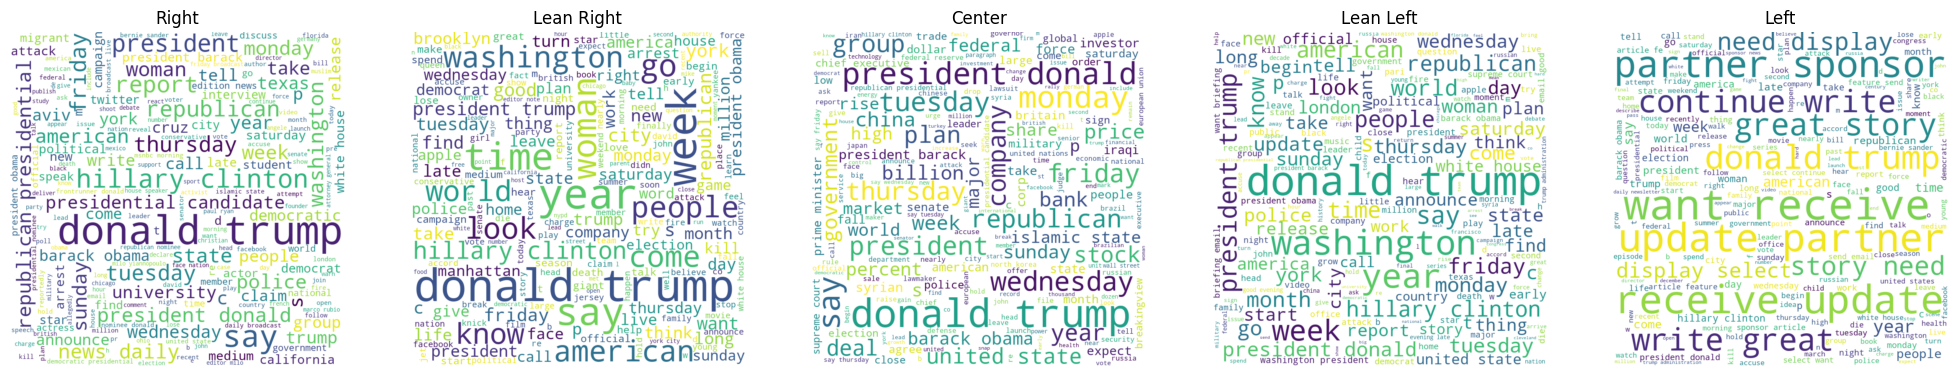

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)

right_wing = sample['content'][sample['bias']=="Right"].to_string()
wordcloud_right = WordCloud(width = 800, height = 800,
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(right_wing)
left_wing = sample['content'][sample['bias']=="Left"].to_string()
wordcloud_left = WordCloud(width = 800, height = 800,
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(left_wing)
lean_right_wing = sample['content'][sample['bias']=="Lean Right"].to_string()
wordcloud_lean_right = WordCloud(width = 800, height = 800,
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(lean_right_wing)
lean_left_wing = sample['content'][sample['bias']=="Lean Left"].to_string()
wordcloud_lean_left = WordCloud(width = 800, height = 800,
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(lean_left_wing)
center_wing = sample['content'][sample['bias']=="Center"].to_string()
wordcloud_center = WordCloud(width = 800, height = 800,
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(center_wing)

# Plotting the WordCloud images
plt.figure(figsize=(25, 5))

clouds = [
    (wordcloud_right, "Right"),
    (wordcloud_lean_right, "Lean Right"),
    (wordcloud_center, "Center"),
    (wordcloud_lean_left, "Lean Left"),
    (wordcloud_left, "Left"),
]

for i, (wc, title) in enumerate(clouds, 1):
    plt.subplot(1, 5, i)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)

# plt.tight_layout()
# plt.savefig("wordcloud.png", dpi=300)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
vec = TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=10, max_df=0.8)

x_sample = vec.fit_transform(sample['content'])
y_sample = le.fit_transform(sample['bias'])  # use same encoder

In [29]:
# SMOTE implementation

from imblearn.over_sampling import SMOTE
from collections import Counter

print('Original dataset shape %s' % Counter(le.inverse_transform(y_sample)))

sm = SMOTE(random_state=42)

x_sample, y_sample = sm.fit_resample(x_sample, y_sample)
print('Resampled dataset shape %s' % Counter(le.inverse_transform(y_sample)))


Original dataset shape Counter({'Lean Left': 14818, 'Right': 14818, 'Center': 14818, 'Left': 14818, 'Lean Right': 14818})
Resampled dataset shape Counter({'Lean Left': 14818, 'Right': 14818, 'Center': 14818, 'Left': 14818, 'Lean Right': 14818})


In [ ]:
X_train, X_test, train_Y, test_Y = train_test_split(x_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

In [ ]:
#Logistic Regression
lr_classifier = LogisticRegression(max_iter=1000)
lr_classifier.fit(X_train, train_Y)

lr_pred = lr_classifier.predict(X_test)

print("Accuracy:", lr_classifier.score(X_test, test_Y))
print(classification_report(le.inverse_transform(test_Y), le.inverse_transform(lr_pred)))
print(confusion_matrix(le.inverse_transform(test_Y), le.inverse_transform(lr_pred)))

Accuracy: 0.7239622641509434
              precision    recall  f1-score   support

      Center       0.97      0.86      0.91       431
   Lean Left       0.64      0.86      0.73      1962
  Lean Right       0.72      0.57      0.64       953
        Left       0.75      0.44      0.56       815
       Right       0.85      0.76      0.80      1139

    accuracy                           0.72      5300
   macro avg       0.79      0.70      0.73      5300
weighted avg       0.74      0.72      0.72      5300

[[ 371   51    2    2    5]
 [   8 1692  106   69   87]
 [   2  325  547   34   45]
 [   0  389   46  358   22]
 [   1  203   54   12  869]]


Cleaned Content: (AP) Republican Donald Trump’s victory in Wisconsin was reaffirmed Monday following a recount that showed him defeating Democrat Hillary Clinton by mo...
Vectorized content shape: (1, 30000)
Predicted Bias Category: Right
Actual Category: Right

SHAP Waterfall Plot for Predicted Class: 'Right'


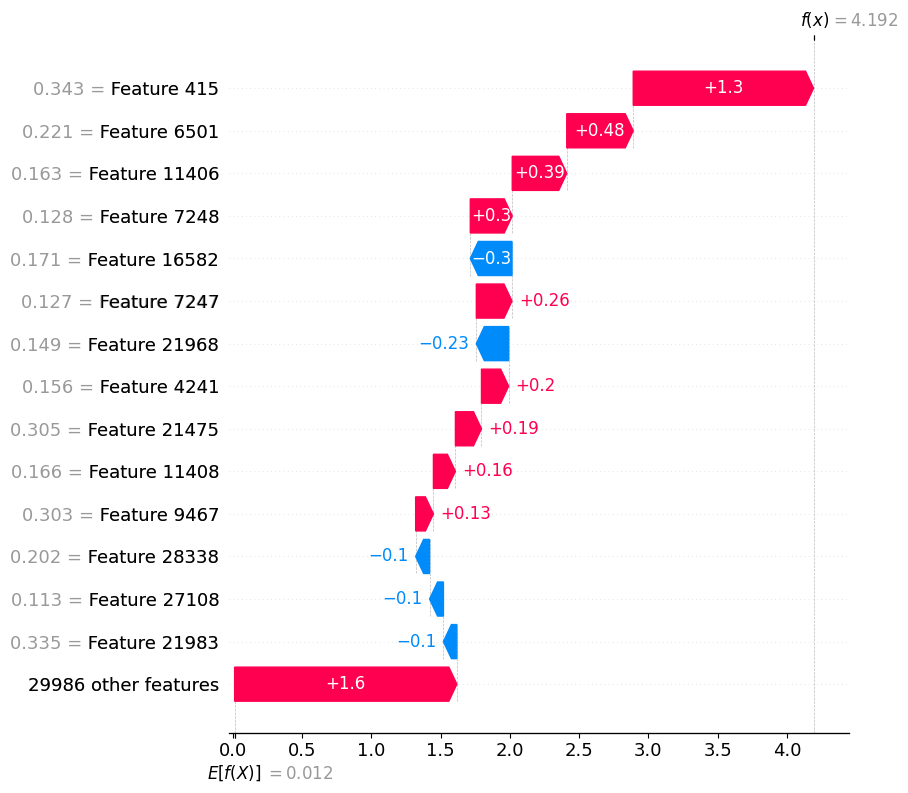


Top 10 Deciding Features for 'Right' class:
  - advertisement: 1.3020
  - democrat: 0.4801
  - hillary: 0.3936
  - donald trump: 0.3029
  - monday: -0.3011
  - donald: 0.2575
  - republican: -0.2333
  - clinton: 0.1962
  - recount: 0.1882
  - hillary clinton: 0.1589


In [ ]:
# Clean the custom content using the previously defined function
import shap

idx = 11

cleaned_custom_content = media_data["content"].iloc[idx]
print(f"Cleaned Content: {cleaned_custom_content[:150]}...")

# Vectorize the cleaned content using the fitted TfidfVectorizer
# The vec object was fitted in cell 'NhGzXaY0OVGG'
vectorized_custom_content = vec.transform([cleaned_custom_content])

print(f"Vectorized content shape: {vectorized_custom_content.shape}")
predicted_label_encoded = lr_classifier.predict(vectorized_custom_content)
predicted_bias = le.inverse_transform(predicted_label_encoded)

print(f"Predicted Bias Category: {predicted_bias[0]}")
print(f"Actual Category: {media_data["bias"].iloc[idx]}")

# Re-initialize the LinearExplainer (if not already done or if kernel was reset)
# Using a small subset of X_train as background data. Keep it sparse.
background_data = X_train
explainer_new_content = shap.LinearExplainer(lr_classifier, background_data)

# Calculate SHAP values for the vectorized custom content
# explainer_new_content.shap_values expects a 2D sparse array
shap_values_new_content = explainer_new_content.shap_values(vectorized_custom_content)

# The predicted_label_encoded[0] gives the index of the predicted class (e.g., 0 for 'Center')
predicted_class_index = predicted_label_encoded[0]
class_name_predicted = le.classes_[predicted_class_index]

# Create a shap.Explanation object for the predicted class and the new instance
explanation_new_content = shap.Explanation(
    values=shap_values_new_content[0, :, predicted_class_index], # Corrected indexing: [sample_idx, :, class_idx]
    base_values=explainer_new_content.expected_value[predicted_class_index], # Base value for the predicted class
    data=vectorized_custom_content[0].toarray().flatten() # 1D dense array for plotting labels
)

print(f"\nSHAP Waterfall Plot for Predicted Class: '{class_name_predicted}'")
shap.plots.waterfall(explanation_new_content, max_display=15)

# Display the top deciding features and their SHAP values
feature_names = vec.get_feature_names_out()
shap_values_for_display = explanation_new_content.values

# Get indices that sort by absolute SHAP value in descending order
sorted_indices = np.argsort(np.abs(shap_values_for_display))[::-1]

print(f"\nTop 10 Deciding Features for '{class_name_predicted}' class:")
for i in range(min(10, len(sorted_indices))):
    idx = sorted_indices[i]
    feature_name = feature_names[idx]
    shap_value = shap_values_for_display[idx]
    print(f"  - {feature_name}: {shap_value:.4f}")

In [35]:
#Random Forest
rm_classifier = RandomForestClassifier(n_jobs=-1)
rm_classifier.fit(X_train, train_Y)

rm_pred = rm_classifier.predict(X_test)

print("Accuracy:", rm_classifier.score(X_test, test_Y))
print(classification_report(le.inverse_transform(test_Y), le.inverse_transform(rm_pred)))
print(confusion_matrix(le.inverse_transform(test_Y), le.inverse_transform(rm_pred)))

Accuracy: 0.84916992846538
              precision    recall  f1-score   support

      Center       0.99      1.00      0.99      2964
   Lean Left       0.67      0.75      0.71      2963
  Lean Right       0.84      0.85      0.85      2964
        Left       0.89      0.79      0.84      2964
       Right       0.87      0.85      0.86      2963

    accuracy                           0.85     14818
   macro avg       0.85      0.85      0.85     14818
weighted avg       0.85      0.85      0.85     14818

[[2955    7    0    2    0]
 [  12 2226  274  192  259]
 [   2  314 2531   33   84]
 [   2  499   76 2346   41]
 [   6  252  130   50 2525]]


In [36]:
#Extra Trees
et_classifier = ExtraTreesClassifier(n_jobs=-1)
et_classifier.fit(X_train, train_Y)

et_pred = et_classifier.predict(X_test)

print("Accuracy:", et_classifier.score(X_test, test_Y))
print(classification_report(le.inverse_transform(test_Y), le.inverse_transform(et_pred)))
print(confusion_matrix(le.inverse_transform(test_Y), le.inverse_transform(et_pred)))

Accuracy: 0.883655014171953
              precision    recall  f1-score   support

      Center       1.00      1.00      1.00      2964
   Lean Left       0.72      0.84      0.78      2963
  Lean Right       0.89      0.86      0.87      2964
        Left       0.93      0.86      0.89      2964
       Right       0.92      0.86      0.89      2963

    accuracy                           0.88     14818
   macro avg       0.89      0.88      0.89     14818
weighted avg       0.89      0.88      0.89     14818

[[2959    5    0    0    0]
 [   8 2494  179  140  142]
 [   2  333 2550   22   57]
 [   0  374   30 2537   23]
 [   1  261  122   25 2554]]


In [26]:
#LinearSVC
svc_classifier = LinearSVC()
svc_classifier.fit(X_train, train_Y)

svc_pred = svc_classifier.predict(X_test)

print("Accuracy:", svc_classifier.score(X_test, test_Y))
print(classification_report(le.inverse_transform(test_Y), le.inverse_transform(svc_pred)))
print(confusion_matrix(le.inverse_transform(test_Y), le.inverse_transform(svc_pred)))

Accuracy: 0.7543396226415094
              precision    recall  f1-score   support

      Center       0.97      0.95      0.96       431
   Lean Left       0.70      0.82      0.76      1962
  Lean Right       0.71      0.63      0.67       953
        Left       0.70      0.56      0.63       815
       Right       0.84      0.80      0.82      1139

    accuracy                           0.75      5300
   macro avg       0.79      0.75      0.77      5300
weighted avg       0.76      0.75      0.75      5300

[[ 409   13    4    2    3]
 [   7 1617  133  115   90]
 [   4  240  604   52   53]
 [   0  278   49  458   30]
 [   2  146   58   23  910]]


In [38]:
#AdaBoost
ab_classifier = AdaBoostClassifier()
ab_classifier.fit(X_train, train_Y)

ab_pred = ab_classifier.predict(X_test)

print("Accuracy:", ab_classifier.score(X_test, test_Y))
print(classification_report(test_Y, ab_pred))
print(confusion_matrix(test_Y, ab_pred))

Accuracy: 0.5730867863409367
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      2964
           1       0.34      0.24      0.28      2963
           2       0.40      0.66      0.50      2964
           3       0.61      0.56      0.58      2964
           4       0.61      0.45      0.52      2963

    accuracy                           0.57     14818
   macro avg       0.59      0.57      0.57     14818
weighted avg       0.59      0.57      0.57     14818

[[2817   16   70   25   36]
 [  15  717 1386  487  358]
 [   5  523 1971  302  163]
 [  24  439  540 1648  313]
 [  12  411  962  239 1339]]


In [39]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), device="cuda", n_estimators=400,)
xgb_classifier.fit(X_train, train_Y)

xgb_pred = xgb_classifier.predict(X_test)

print("Accuracy:", xgb_classifier.score(X_test, test_Y))
print(classification_report(test_Y, xgb_pred))
print(confusion_matrix(test_Y, xgb_pred))

c:\Users\Host\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:774: UserWarning: [12:11:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Accuracy: 0.333513294641652
              precision    recall  f1-score   support

           0       0.31      0.59      0.40      2964
           1       0.27      0.01      0.03      2963
           2       0.40      0.16      0.23      2964
           3       0.37      0.45      0.41      2964
           4       0.32      0.45      0.37      2963

    accuracy                           0.33     14818
   macro avg       0.33      0.33      0.29     14818
weighted avg       0.33      0.33      0.29     14818

[[1740   26   73  682  443]
 [1010   41  321  636  955]
 [1083   23  487  463  908]
 [ 911   46   77 1326  604]
 [ 893   14  269  439 1348]]


In [40]:
#Multinomial Naive Bayes
mnb_classifier = MultinomialNB()
mnb_classifier.fit(X_train, train_Y)

mnb_pred = mnb_classifier.predict(X_test)

print("Accuracy:", mnb_classifier.score(X_test, test_Y))
print(classification_report(test_Y, mnb_pred))
print(confusion_matrix(test_Y, mnb_pred))

Accuracy: 0.6797813470103927
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2964
           1       0.57      0.42      0.48      2963
           2       0.70      0.55      0.62      2964
           3       0.62      0.70      0.66      2964
           4       0.67      0.79      0.73      2963

    accuracy                           0.68     14818
   macro avg       0.67      0.68      0.67     14818
weighted avg       0.67      0.68      0.67     14818

[[2751   83   38   29   63]
 [ 258 1251  386  590  478]
 [ 185  290 1643  475  371]
 [ 132  376  149 2080  227]
 [ 101  206  143  165 2348]]


In [ ]:
# 8. Data Preprocessing-2  for 'content' attribute

# out of vocabulary token to handle unseen words
# Don’t use the full vocabulary. Many rare words add noise. Limit to top N words
tokenizer = Tokenizer(num_words=30000, oov_token="<OOV>")
tokenizer.fit_on_texts(sample['content'])

# Fresh split without SMOTE
X_train, X_test, y_train, y_test = train_test_split(sample['content'], sample['bias'], test_size=0.2, random_state=42)

X_train_dnn = tokenizer.texts_to_sequences(X_train)
X_test_dnn = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

max_len = 800

#padding to make the input size consistent
X_train_final = pad_sequences(X_train_dnn, padding='post', maxlen=max_len)
X_test_final = pad_sequences(X_test_dnn, padding='post', maxlen=max_len)

print("Vocab Size: ",vocab_size)

Vocab Size:  137053


In [ ]:
# 9. Creating DNN model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout

embedding_dim = 128

# Model design
model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 800, 128)       │    17,542,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 800, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,650,181 (67.33 MB)

 Trainable params: 17,650,181 (67.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 11. Model fitting
callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model_data = model.fit(X_train_final, train_Y, validation_split=0.20, epochs=6, batch_size=64,callbacks=[callback])

Epoch 1/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 324s 809ms/step - accuracy: 0.1959 - loss: 1.6101 - val_accuracy: 0.1987 - val_loss: 1.6095
Epoch 2/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 307s 772ms/step - accuracy: 0.2203 - loss: 1.6073 - val_accuracy: 0.1991 - val_loss: 1.6137
Epoch 3/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 299s 751ms/step - accuracy: 0.2980 - loss: 1.5591 - val_accuracy: 0.1951 - val_loss: 1.6434
Epoch 4/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 324s 815ms/step - accuracy: 0.5415 - loss: 1.1822 - val_accuracy: 0.1926 - val_loss: 1.9566
Epoch 5/10
296/398 ━━━━━━━━━━━━━━━━━━━━ 1:27 863ms/step - accuracy: 0.8458 - loss: 0.5265

KeyboardInterrupt: 

In [27]:
# 12. Model prediction with scores
score = model.evaluate(X_test_final, test_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7017313838005066
Test accuracy: 0.7592452764511108


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

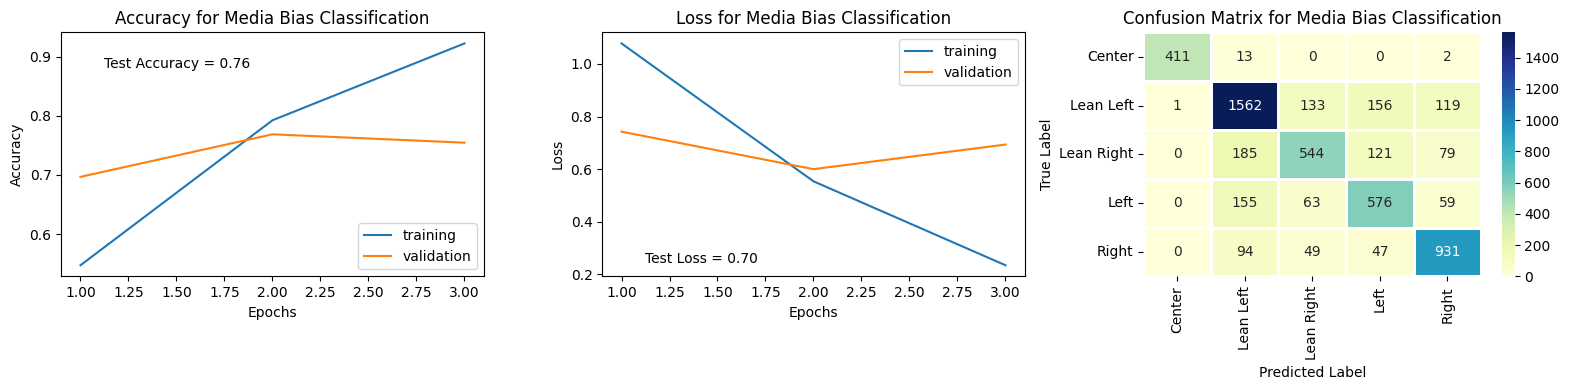

In [28]:
# 13. Visualization

import seaborn as sns
from sklearn.metrics import confusion_matrix

epochs = np.arange(1, len(model_data.history['accuracy']) + 1)
y_pred_probabilities = model.predict(X_test_final)
y_pred = np.argmax(y_pred_probabilities, axis=1)
class_names = le.inverse_transform(np.arange(len(le.classes_)))

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

with sns.color_palette("Accent", n_colors=8):
    sns.lineplot(x=epochs, y=model_data.history['accuracy'], ax=axes[0], label='training')
    sns.lineplot(x=epochs, y=model_data.history['val_accuracy'], ax=axes[0], label='validation')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy for Media Bias Classification")
axes[0].legend(loc='lower right')
axes[0].text(0.1, 0.9, f'Test Accuracy = {score[1]:.2f}',
            transform=axes[0].transAxes, ha='left', va='top')

with sns.color_palette("Accent", n_colors=8):
    sns.lineplot(x=epochs, y=model_data.history['loss'], ax=axes[1], label='training')
    sns.lineplot(x=epochs, y=model_data.history['val_loss'], ax=axes[1], label='validation')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss for Media Bias Classification")
axes[1].legend(loc='upper right')
axes[1].text(0.1, 0.1, f'Test Loss = {score[0]:.2f}',
            transform=axes[1].transAxes, ha='left', va='top')

sns.heatmap(confusion_matrix(test_Y, y_pred),
            annot=True, linewidths=2, cmap="YlGnBu", fmt="g",
            xticklabels=class_names, yticklabels=class_names, ax=axes[2])
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')
axes[2].set_title("Confusion Matrix for Media Bias Classification")

fig.tight_layout()
plt.show()

In [ ]:
# 10. Creating CNN Model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout

callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# CNN Model design
cnn_model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
    callbacks=[callback]
)

cnn_model.build(input_shape=(None, max_len))
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 800, 128)       │    37,282,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 796, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,372,805 (142.57 MB)

 Trainable params: 37,372,805 (142.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 11. Model fitting

cnn_model_data = cnn_model.fit(X_train_final, train_Y, validation_split=0.20, epochs=6, batch_size=32)

Epoch 1/3


I0000 00:00:1763121559.934799     178 service.cc:148] XLA service 0x7f22b4029e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763121559.935631     178 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763121559.935648     178 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  9/530 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1450 - loss: 1.6077

I0000 00:00:1763121562.415087     178 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


530/530 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.4896 - loss: 1.2096 - val_accuracy: 0.7191 - val_loss: 0.6744
Epoch 2/3
530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8354 - loss: 0.4594 - val_accuracy: 0.7809 - val_loss: 0.5648
Epoch 3/3
530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9854 - loss: 0.0779 - val_accuracy: 0.7599 - val_loss: 0.7377


In [31]:
# 12. Model prediction with scores

cnn_score = cnn_model.evaluate(X_test_final, test_Y, verbose=0)
print('Test loss:', cnn_score[0])
print('Test accuracy:', cnn_score[1])

Test loss: 0.6883534789085388
Test accuracy: 0.7698113322257996


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

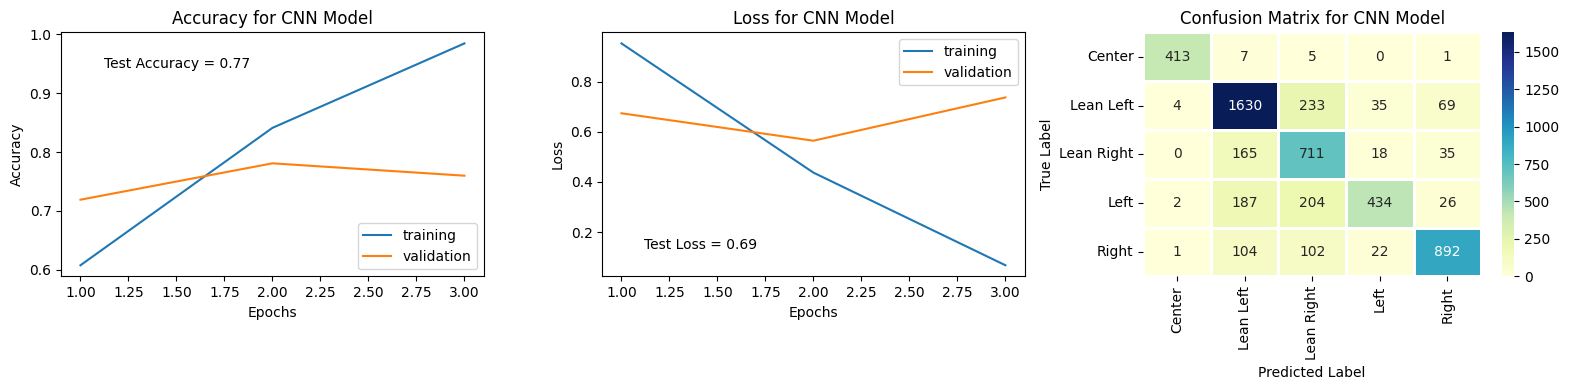

In [36]:
# 13. Visualization

import seaborn as sns
from sklearn.metrics import confusion_matrix

epochs = np.arange(1, len(cnn_model_data.history['accuracy']) + 1)
cnn_y_pred_probabilities = cnn_model.predict(X_test_final)
cnn_y_pred = np.argmax(cnn_y_pred_probabilities, axis=1)
class_names = le.inverse_transform(np.arange(len(le.classes_)))

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

with sns.color_palette("Accent", n_colors=8):
    sns.lineplot(x=epochs, y=cnn_model_data.history['accuracy'], ax=axes[0], label='training')
    sns.lineplot(x=epochs, y=cnn_model_data.history['val_accuracy'], ax=axes[0], label='validation')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy for CNN Model")
axes[0].legend(loc='lower right')
axes[0].text(0.1, 0.9, f'Test Accuracy = {cnn_score[1]:.2f}',
            transform=axes[0].transAxes, ha='left', va='top')

with sns.color_palette("Accent", n_colors=8):
    sns.lineplot(x=epochs, y=cnn_model_data.history['loss'], ax=axes[1], label='training')
    sns.lineplot(x=epochs, y=cnn_model_data.history['val_loss'], ax=axes[1], label='validation')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss for CNN Model")
axes[1].legend(loc='upper right')
axes[1].text(0.1, 0.1, f'Test Loss = {cnn_score[0]:.2f}',
            transform=axes[1].transAxes, ha='left', va='bottom')

sns.heatmap(confusion_matrix(test_Y, cnn_y_pred),
            annot=True, linewidths=2, cmap="YlGnBu", fmt="g",
            xticklabels=class_names,
            yticklabels=class_names,
            ax=axes[2])
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')
axes[2].set_title("Confusion Matrix for CNN Model")

fig.tight_layout()
plt.show()


In [ ]:
from transformers import DistilBertTokenizerFast
from datasets import Dataset
import multiprocessing

# CPU cores for parallelism
NUM_CORES = multiprocessing.cpu_count()

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_dict({"text": X_train.tolist(), "label": train_Y.tolist()})
test_dataset = Dataset.from_dict({"text": X_test.tolist(), "label": test_Y.tolist()})

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Fast batch tokenization
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512  # adjust if texts are long
    )

# Apply tokenization in parallel
train_dataset = train_dataset.map(tokenize_function, batched=True, num_proc=NUM_CORES)
test_dataset = test_dataset.map(tokenize_function, batched=True, num_proc=NUM_CORES)

# Format for TensorFlow
train_dataset.set_format(type="tf", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="tf", columns=["input_ids", "attention_mask", "label"])

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Training setup
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # you can add metrics if needed
)

# Train
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_48/368350009.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.676300,0.617321,0.767547,0.772701,0.767547,0.765311
2,0.484200,0.520272,0.805094,0.807154,0.805094,0.803321
3,0.397400,0.507044,0.817925,0.816901,0.817925,0.816776


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1989, training_loss=0.6072177378720168, metrics={'train_runtime': 1939.3593, 'train_samples_per_second': 32.794, 'train_steps_per_second': 1.026, 'total_flos': 8425377294336000.0, 'train_loss': 0.6072177378720168, 'epoch': 3.0})

In [ ]:
# Evaluate

eval_results = trainer.evaluate()
distilbert_accuracy = eval_results['eval_accuracy']

print(eval_results)
print(f"DistilBERT Accuracy: {distilbert_accuracy}")

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.5070436000823975, 'eval_accuracy': 0.8179245283018868, 'eval_precision': 0.816900681622155, 'eval_recall': 0.8179245283018868, 'eval_f1': 0.8167761878389409, 'eval_runtime': 53.0645, 'eval_samples_per_second': 99.878, 'eval_steps_per_second': 3.128, 'epoch': 3.0}
DistilBERT Accuracy: 0.8179245283018868


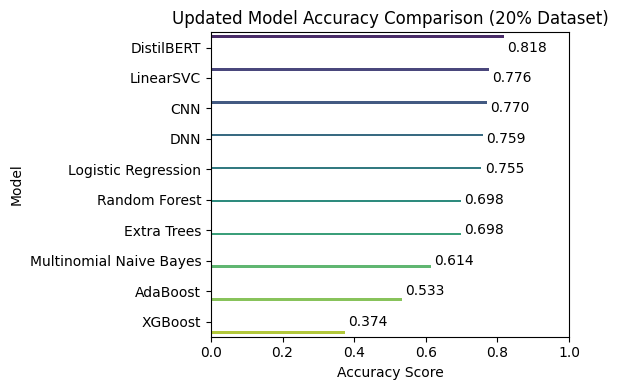

In [ ]:
# 13. Visualization and Model Comparison

model_names = [
    "Logistic Regression",
    "Random Forest",
    "Extra Trees",
    "LinearSVC",
    "AdaBoost",
    "XGBoost",
    "Multinomial Naive Bayes",
    "DNN",
    "CNN",
    "DistilBERT"
]

# X_test_for_sklearn was already created using tfidf_transformer.transform(vectorizer.transform(test_X))
accuracy_scores = [
    lr_classifier.score(X_test, test_Y),
    rm_classifier.score(X_test, test_Y),
    et_classifier.score(X_test, test_Y),
    svc_classifier.score(X_test, test_Y),
    ab_classifier.score(X_test, test_Y),
    xgb_classifier.score(X_test, test_Y),
    mnb_classifier.score(X_test, test_Y),
    score[1], # DNN accuracy
    cnn_score[1], # CNN accuracy
    distilbert_accuracy
]

# Create a DataFrame for easy plotting
comparison_df_updated = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_scores
})

# Sort by accuracy for better visualization
comparison_df_updated = comparison_df_updated.sort_values(by='Accuracy', ascending=False)

# Create the bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x='Accuracy', y='Model', hue='Model', data=comparison_df_updated, palette='viridis')
plt.legend().remove()
plt.title('Updated Model Accuracy Comparison (30% Dataset)')
plt.xlabel('Accuracy Score')
plt.ylabel('Model')
plt.xlim(0, 1) # Set x-axis limit from 0 to 1 for accuracy

# Add accuracy values on the bars, using enumerate for correct y-position
for i, (index, row) in enumerate(comparison_df_updated.iterrows()):
    plt.text(row.Accuracy + 0.01, i, f'{row.Accuracy:.3f}', color='black', ha="left", va="center")

plt.tight_layout()
plt.show()